# Multi-class Classification and Neural Networks
For this exercise, you will use logistic regression and neural networks to
recognize handwritten digits (from 0 to 9). Automated handwritten digit
recognition is widely used today - from recognizing zip codes (postal codes)
on mail envelopes to recognizing amounts written on bank checks. This
exercise will show you how the methods you’ve learned can be used for this
classification task.

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.io
from scipy.misc import toimage
import random
matplotlib.style.use('seaborn-notebook')


In [14]:
#First bring in the data 
datafile = 'data/ex3data1.mat'
mat = scipy.io.loadmat( datafile )
X, y = mat['X'], mat['y']
#Insert a column of 1's to X as usual
X = np.insert(X,0,1,axis=1)
print ' size of dataset {}'.format(len(X))
# Note each row is a series of 400 pixels coming from a 20X20 image Note the length is 401 dues to bias
# Y is the labels... which run from 1-10 with 10=0

 size of dataset 5000


### Vizualize the data

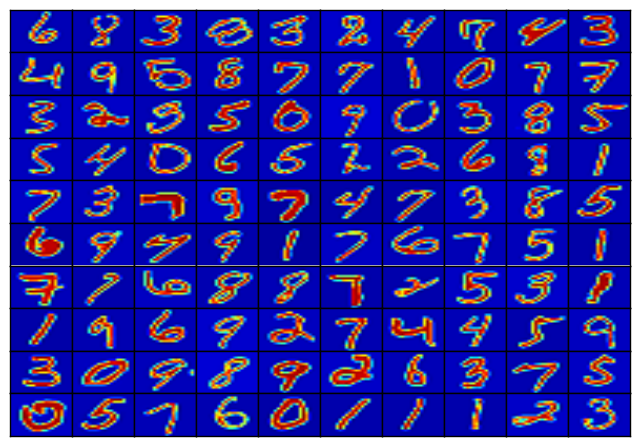

In [3]:
def get_image(data_idx):
    width, height = 20, 20 # 20 X 20 pixels
    thedataimg = X[data_idx][1:].reshape(width,height).T
    return toimage(thedataimg)# get it as an image 

def make_images_mat(image_list):
    extent = np.sqrt(len(image_list))
    width = extent
    height = extent 
    if extent%int(extent)!=0:# not a perfect square
        width = int(extent) + int(extent%int(extent)+0.5) +1 #ugly... but it works
        height = int(extent) #leaves the bottom row partially filled
    #loop over the images
    for i, image in enumerate(image_list):
        #print i
        plt.subplot(int(width), int(height), i + 1)  
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imshow(image, aspect='auto')
    
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()
    
#some random images 
some_images = [ get_image(random.randint(0,len(X))) for x in range(100)]
make_images_mat(some_images)

### Vectorized Logistical Regression

Here  we will need to train for 10 seperate classifiers. a one vs all style 

In [4]:
#Copied from previous notebooks

# my sigmoid function
def my_sigmoid(x):
    return 1./(1+np.exp(-1.*x))

# Definition of hypothsis
def h(theta,x):
    return my_sigmoid(np.dot(x,theta)) # This is hypothesis for one entry

# Definition for vectorized hypothesis 
def h_vectorize(theta,x):
    return my_sigmoid(np.matmul(x,theta)) # note here we are using matrix multiplication to vectorize

# Regularized, vectorize, awesome-ized cost function 
def cost_logistic_reg_vectorize(Theta_values,X,myy,reg_lambda = 1 ): # Lambda = 0 means no reg applied
    first_term = np.matmul(-np.transpose(myy),np.log(h_vectorize(Theta_values,X)))
    second_term = np.matmul(np.transpose(1-myy),np.log(1-h_vectorize(Theta_values,X)))
    reg_term = (reg_lambda /2.) * np.sum(np.dot(np.transpose(Theta_values[1:]),Theta_values[1:]))
    j = (1./len(myy))* (np.sum(first_term-second_term)+reg_term)
    rj = np.array([j])#apparently this needs to be a 1d array for the scipy min_bfgs
    return rj

# Calculate the gradiants
def mygrads(thetas,X,myy,mylambda=1):
    beta= h_vectorize(thetas,X)-myy
    grads = 1./(len(myy)) * np.matmul(X.T,beta)# again we use matmul since things are vectorized
    #reg term skips the first element in theta
    regterm = thetas[1:]*(mylambda/(len(myy)))
    grads[1:] = grads[1:]+regterm
    grads = grads.reshape((401,)) # apperently this needs to be a 1d array
    return grads


In [5]:
# Check to see if the cost seems reasonable 
firsty =np.array([1 if x == 6 else 0 for x in y]) # we will use a 1 vs all... e.g. 6=True , else =0
Initial_Thetas = np.zeros((X.shape[1],1))
cost_logistic_reg_vectorize(Initial_Thetas,X,firsty) #What is the cost?

array([ 0.69314718])

In [6]:
from scipy import optimize#Now optimize the function

def optimizeTheta(mytheta,myX,myy,mylambda=1.):
    result = optimize.fmin_bfgs(cost_logistic_reg_vectorize, fprime=mygrads, x0=mytheta,args=(myX, myy, mylambda), maxiter=500, disp=False, full_output=True)
    return result[0], result[1]

In [7]:
#use y_case again and a see ifoptimization works 
case_thetas , case_cost = optimizeTheta(Initial_Thetas,X,firsty)
print 'This is the cose after the optimization {0:.3f}'.format(case_cost) 

This is the cose after the optimization 0.035


In [8]:
# Optimize as one vs all for all the channels
def MakeThetas():
    Initial_Thetas = np.zeros((X.shape[1],1))# 401 X 1
    Thetas_Class = np.zeros((10,X.shape[1]))# 10 X 401
 
    for current_case in range(10):
        case_itr = current_case
        if current_case==0:
            case_itr=10
        y_case =np.array([1 if x == case_itr else 0 for x in y])
        #run optimization. 
        case_thetas , case_cost = optimizeTheta(Initial_Thetas,X,y_case)
        #store the thetas
        Thetas_Class[current_case,:] = case_thetas
        print 'completed traning for case:{}'.format(current_case)
    print 'Finished Training!'
    return Thetas_Class
Trained_Thetas = MakeThetas()

completed traning for case:0
completed traning for case:1
completed traning for case:2
completed traning for case:3
completed traning for case:4
completed traning for case:5
completed traning for case:6
completed traning for case:7
completed traning for case:8
completed traning for case:9
Finished Training!


In [9]:
#Now... make a function to return the predicted value of an image def Predict_Image(X)
def Predict_Image(Img_itr):
    #loop over all traning and pick the hightest 1 vs all probability
    largest_prob = 0.0
    The_digit = 0

    if Img_itr>len(X):    # Catch for going out of bounds 
        print 'Not a valid index in the dataset'# or just don't mess up so you don't have to see this
    #loop over the digits
    for test_dig in range(10):
        test_prob = h(Trained_Thetas[test_dig],X[Img_itr])#do not use vectorized
        if test_prob>largest_prob:
            largest_prob=test_prob # update the largest prob
            The_digit=test_dig # the index is the digit number
    return The_digit

In [10]:
# The training set accuracy is about 94.9%
def Model_acc():
    N_True = 0.
    for i in range(len(X)):
        pred_dig = Predict_Image(i)
        if pred_dig==0:
            pred_dig=10# stupid shifting the numbers
        if pred_dig == y[i]:
            N_True+=1
    return N_True/len(X)

# function to get the index values for the wrong predictions
def Wrong_Event_list():
    wrong_itr = []
    for i in range(len(X)):
        pred_dig = Predict_Image(i)
        if pred_dig==0:
            pred_dig=10# stupid shifting the numbers
        if pred_dig != y[i]:
            wrong_itr.append(i)
    return wrong_itr
print 'This one vrs all model return {0:.1f}%  accuracy'.format(Model_acc()*100.)

This one vrs all model return 94.5%  accuracy


This one vrs all model return 94.5%  accuracy


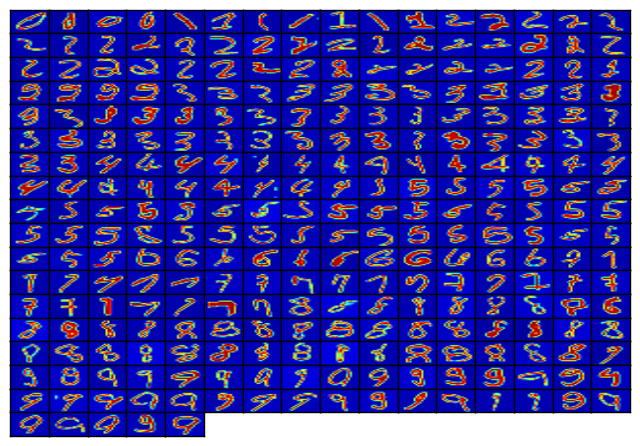

In [11]:
print 'This one vrs all model return {0:.1f}%  accuracy'.format(Model_acc()*100.)
#see some of the bad events 
bad_events = Wrong_Event_list()
    
#some random images 
some_images = [ get_image(x) for x in bad_events]
make_images_mat(some_images)

## Neural networks 


In [17]:
# Here the theta1 and theta2 are already provided in ex3weights. We don't need to train them 
datafile = 'data/ex3weights.mat'
matwts = scipy.io.loadmat( datafile )
Theta1, Theta2 = matwts['Theta1'], matwts['Theta2']
print "This is the Theta1 shape:",Theta1.shape #This is the hidden layer
print "This is the Theta2 shape:",Theta2.shapeT# This is for the output

This is the Theta1 shape: (25, 401)
This is the Theta2 shape: (10, 26)


### Forward Propagation 

In [33]:
# Write a function that takes in a row from the sample 
# propagate it through the entire network 
# Each layer of the network we will use the output features as input to the next layer 
def forward_propagate(row,wts):
    feat = row # This is the features from the input layer
    for layer in range(len(wts)):# we go all the way through up to the last layer: -1 since we want the last features
        
        ta = np.dot(wts[layer],feat)##calculate weight.a
        out_wts = my_sigmoid(ta)# This is the output from the layer 
        if layer==len(wts)-1: # return the last layer weights
            return out_wts
        out_wts = np.insert(out_wts,0,1) #Add bias unit
        feat = out_wts #keep going till we reach the last layer
        
#a function that takes the input image,  runs over all the cases and return back the highest probablity case 
def Predict_Number(row,model_wts):
    res = forward_propagate(row,model_wts)    #remeber 0 = 10... so we will run the results from 1-10
    return np.argmax(res) +1  

In [37]:
#look at the whole dataset again .. we should see something like 97.5%
Model_weights = [Theta1,Theta2]
def NN_Model_acc():
    N_True = 0.
    for i in range(len(X)):
        pred_dig = Predict_Number(X[i],Model_weights)
        if pred_dig == y[i]:
            N_True+=1
    return N_True/len(X)
print 'accuracy of the Neutal Network is {}%'.format(NN_Model_acc()*100)


accuracy of the Neutal Network is 97.52%
